In [58]:
!pip3 install finance-datareader==0.9.42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# 함수

In [ ]:
def getCloseData(ticker, start, end=None): #FinanceDataReader 에서 값 가져오기
    return fdr.DataReader(ticker, start, end)['Close']
def getCloseDataPandas(ticker, start, end=None): #PandasDataReader 에서 값 가져오기
    return data.get_data_yahoo(ticker, start, end)['Close']

In [ ]:
def getDayReturn(closeDataSet): #개별 종목 일별 수익률 : 전날종가/오늘종가
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)
def getCumulativeReturn(closeDataSet): #개별 종목 누적 수익률 : 자산흐름
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight: # 동일 비중
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period)
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]*len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        
    portfolio = pd.DataFrame() 
    totalAsset = 1 
    start = rebalancingDate[0] 
    
    for end in rebalancingDate[1:]:
        # print("*"*50)
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
        # print(end,weightedCumReturn)
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

# 평균 모멘텀 스코어 _ 단일

In [ ]:
test =getCloseData("069500","2021-09-01") #test data
rebalDate = getRebalancingDate(test) #rebalancing_date
priceOnRebalDate = test.loc[rebalDate] #rebal_close_data
test_data = pd.DataFrame(priceOnRebalDate, columns=['Close'])

In [ ]:
# n개월 모멘텀 한번에 구하기
n= 12

for i in range(len(priceOnRebalDate)-1,-1,-1):
  tmp =0
  if i>(n-1):
    for j in range(i-1,i-n-1, -1):
      if priceOnRebalDate[i]>priceOnRebalDate[j] : tmp = tmp+1
      print(i,j,priceOnRebalDate[i],priceOnRebalDate[j],tmp)
  test_data['Close'][i] = tmp/n

14 13 30265 29965 1
14 12 30265 28176 2
14 11 30265 32117 2
14 10 30265 32272 2
14 9 30265 30700 2
14 8 30265 35239 2
14 7 30265 35309 2
14 6 30265 36344 2
14 5 30265 35879 2
14 4 30265 35531 2
14 3 30265 39016 2
14 2 30265 36628 2
13 12 29965 28176 1
13 11 29965 32117 1
13 10 29965 32272 1
13 9 29965 30700 1
13 8 29965 35239 1
13 7 29965 35309 1
13 6 29965 36344 1
13 5 29965 35879 1
13 4 29965 35531 1
13 3 29965 39016 1
13 2 29965 36628 1
13 1 29965 37993 1
12 11 28176 32117 0
12 10 28176 32272 0
12 9 28176 30700 0
12 8 28176 35239 0
12 7 28176 35309 0
12 6 28176 36344 0
12 5 28176 35879 0
12 4 28176 35531 0
12 3 28176 39016 0
12 2 28176 36628 0
12 1 28176 37993 0
12 0 28176 39249 0


In [ ]:
def avgMomentumScoretable1(data, n):
  result = pd.DataFrame(data, columns=['Close'])
  for i in range(len(data)-1,-1,-1):
    tmp =0
    if i>(n-1):
      for j in range(i-1,i-n-1, -1):
        if priceOnRebalDate[i]>priceOnRebalDate[j] : tmp = tmp+1
    result['Close'][i] = tmp/n
  return result

### test

In [ ]:
#test
kodex200 = getCloseData("069500", "2020", "2022-7-30")
rebalDate = getRebalancingDate(kodex200)
priceOnRebalDate =  kodex200.loc[rebalDate]
test_data = pd.DataFrame(priceOnRebalDate, columns=['Close'])

In [ ]:
# n개월 모멘텀 한번에 구하기
n= 6

for i in range(len(priceOnRebalDate)-1,-1,-1):
  tmp =0
  if i>(n-1):
    for j in range(i-1,i-n-1, -1):
      if priceOnRebalDate[i]>priceOnRebalDate[j] : tmp = tmp+1
      # print(i,j,priceOnRebalDate[i],priceOnRebalDate[j],tmp)
  test_data['Close'][i] = tmp

test_data['check'] = test_data['Close']/float(n) 
test_data

,Close,check
Date,,
2020-01-31,0,0.000000
2020-02-28,0,0.000000
2020-03-31,0,0.000000
2020-04-29,0,0.000000
2020-05-29,0,0.000000
2020-06-30,0,0.000000
2020-07-31,6,1.000000
2020-08-31,6,1.000000
2020-09-29,6,1.000000


# 평균 모멘텀 스코어_ 다중

In [ ]:
test1 =getCloseData("069500","2020", "2022-07-30") #test data
test2 = getCloseData("152380", "2020","2022-7-30")

closeDataSet = pd.concat([test1, test2], axis=1)
closeDataSet.columns = ['test1','test2']
closeDataSet.dropna(inplace=True)
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [ ]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [ ]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

### test

In [ ]:
n=6
test_avgMomentumScore6= avgMomentumScoretable(priceOnRebalDate, n)
test_weight6 = weightScore(test_avgMomentumScore6)

In [ ]:
test_avgMomentumScore6

,test1,test2
Date,,
2020-07-31,1.000000,1.000000
2020-08-31,1.000000,0.333333
2020-09-29,1.000000,0.500000
2020-10-30,0.666667,0.166667
2020-11-30,1.000000,0.000000
2020-12-30,1.000000,0.000000
2021-01-29,1.000000,0.000000
2021-02-26,1.000000,0.000000
2021-03-31,1.000000,0.000000


In [ ]:
test_weight6

,test1,test2,cash
Date,,,
2020-07-31,0.500000,0.500000,0
2020-08-31,0.750000,0.250000,0
2020-09-29,0.666667,0.333333,0
2020-10-30,0.800000,0.200000,0
2020-11-30,1.000000,0.000000,0
2020-12-30,1.000000,0.000000,0
2021-01-29,1.000000,0.000000,0
2021-02-26,1.000000,0.000000,0
2021-03-31,1.000000,0.000000,0


### again

In [ ]:
n=12
avgMomentumScore12= avgMomentumScoretable(priceOnRebalDate, n)
weight12 = weightScore(avgMomentumScore12)
#avgMomentumScore12
#weight12

In [ ]:
closeDataSet['cash'] =1

In [ ]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet)
print(f"12개월 동일 비중 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 동일 비중 평균 모멘텀 스코어 최종수익률: 1.0396107507347072
최종 수익률: 1.0396107507347072
cagr: 1.0159403890414278
mdd: 14.228638030837782


In [ ]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)
print(f"12개월 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 평균 모멘텀 스코어 최종수익률: 1.111506879426256
최종 수익률: 1.111506879426256
cagr: 1.074448526755126
mdd: 9.60841768392284


# regime
- 주식과 채권의 평균 모멘텀 평균으로 결정
- 비정상적으로 낮은 경우 -> 비정상적인 장 판정
- 주식과 채권의 모멘터의 평균 : 0.2~0.4 
- 0.3 이하 : 주식, 장기 채권 대신 달러 etf 편입

In [ ]:
test1 =getCloseData("069500","2020", "2022-07-30") #test data
test2 = getCloseData("152380", "2020","2022-7-30")

closeDataSet = pd.concat([test1, test2], axis=1)
closeDataSet.columns = ['test1','test2']
closeDataSet.dropna(inplace=True)
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data


In [ ]:
n=12
avg_1= avgMomentumScoretable(priceOnRebalDate, n)
weg_1 = weightScore(avg_1)
avg_1['cash'] =1
avg_1['avg'] = (avg_1['test1'] +avg_1['test2'])/2
avg_1["dollar"] = np.where( avg_1["avg"].values < 0.3 , 1,0 )

In [ ]:
weg_1['test1'] =np.where(avg_1['avg'].values < 0.3,1-avg_1['test1'],weg_1['test1'])
weg_1['test2'] =np.where(avg_1['avg'].values < 0.3,1-avg_1['test2'],weg_1['test2'])

# 달러
- 종가만 남겨둠
- avg_1 인덱스 날짜를 받아와 해당 날짜의 달러값 추출

In [ ]:
usdkrw = pd.DataFrame(index = avg_1.index, columns=["Close"])

In [ ]:
dd = fdr.DataReader('USD/KRW', '2012-01-20', '2022-09-30')['Close']
for date in usdkrw.index :
  date = str(date)[:10]
  usdkrw.loc[date] = dd.loc[date]

In [ ]:
usdkrw

,Close
Date,
2021-01-29,1117.64
2021-02-26,1123.89
2021-03-31,1127.17
2021-04-30,1117.16
2021-05-31,1106.58
2021-06-30,1130.48
2021-07-30,1151.41
2021-08-31,1158.73
2021-09-30,1184.23


# 최종

In [60]:
kospi =getCloseData("069500","2017-9","2022-09-30") #코스피200  2002-10-14
kodex10Bond = getCloseData("152380", "2017-9","2022-09-30") #장기 국채 2012-01-20

# kospi =getCloseData("069500","2012-10-01","2022-09-30") #코스피200  2002-10-14
# kodex10Bond = getCloseData("152380", "2012-10-01","2022-09-30") #장기 국채 2012-01-20

In [61]:
closeDataSet = pd.concat([kospi,kodex10Bond], axis=1)
closeDataSet.columns = ["kospi","kodex10Bond"]
closeDataSet.dropna(inplace = True)

rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [62]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [63]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [64]:
n=12
avgMomentumScore12= avgMomentumScoretable(priceOnRebalDate, n)
weight12 = weightScore(avgMomentumScore12)
avgMomentumScore12['cash'] =1

In [65]:
avgMomentumScore12['avg'] = (avgMomentumScore12['kospi'] +avgMomentumScore12['kodex10Bond'])/2
avgMomentumScore12["dollar"] = np.where( avgMomentumScore12["avg"].values < 0.3 , 1,0 )

In [66]:
weight12['kospi'] =np.where(avgMomentumScore12['avg'].values < 0.3,1-avgMomentumScore12['kospi'],weight12['kospi'])
weight12['kodex10Bond'] =np.where(avgMomentumScore12['avg'].values < 0.3,1-avgMomentumScore12['kodex10Bond'],weight12['kodex10Bond'])

# dollar

In [89]:
dd = fdr.DataReader('USD/KRW', '2012-01-20', '2022-09-30')['Close']
# dd = getCloseData("261240", "2017-9", "2022-9-30") # 달러 ETF

In [90]:
dd

Date
2012-01-20    1133.50
2012-01-23    1128.15
2012-01-24    1130.05
2012-01-25    1127.55
2012-01-26    1122.50
               ...   
2022-09-26    1430.19
2022-09-27    1426.32
2022-09-28    1424.48
2022-09-29    1429.99
2022-09-30    1439.96
Name: Close, Length: 2791, dtype: float64

In [69]:
use_dollar_date = avgMomentumScore12[avgMomentumScore12['dollar'] ==1].index

usdkrw_data = pd.DataFrame.copy(closeDataSet)
usdkrw_data.columns=["data1","data2"]

In [70]:
for date in use_dollar_date :
  date = str(date)[:10]
  usdkrw_data.loc[date]['data1'] = dd.loc[date]
  usdkrw_data.loc[date]['data2'] = 1

In [71]:
usdkrw_weight = pd.DataFrame(index = weight12.index)
usdkrw_weight["data1"] = np.where( avgMomentumScore12["dollar"].values ==1 , weight12['kospi']+weight12['kodex10Bond'],weight12['kospi'] )
usdkrw_weight["data2"] = np.where( avgMomentumScore12["dollar"].values ==1 , 1,weight12['kodex10Bond'] )
usdkrw_weight["sum"] = usdkrw_weight["data1"]+usdkrw_weight["data2"]
usdkrw_weight

,data1,data2,sum
Date,,,
2018-09-28,0.214286,0.785714,1.000000
2018-10-31,0.000000,1.000000,1.000000
2018-11-30,0.076923,0.923077,1.000000
2018-12-28,0.076923,0.923077,1.000000
2019-01-31,0.214286,0.785714,1.000000
2019-02-28,0.214286,0.785714,1.000000
2019-03-29,0.200000,0.800000,1.000000
2019-04-30,0.312500,0.687500,1.000000
2019-05-31,0.142857,0.857143,1.000000


In [72]:
usdkrw_weight["data1"] = np.where( avgMomentumScore12["dollar"].values ==1 , usdkrw_weight["data1"]/usdkrw_weight["sum"],usdkrw_weight["data1"] )
usdkrw_weight["data2"] = np.where( avgMomentumScore12["dollar"].values ==1 , usdkrw_weight["data2"]/usdkrw_weight["sum"],usdkrw_weight["data2"] )
usdkrw_weight=usdkrw_weight.drop(['sum'],axis=1)
usdkrw_weight

,data1,data2
Date,,
2018-09-28,0.214286,0.785714
2018-10-31,0.000000,1.000000
2018-11-30,0.076923,0.923077
2018-12-28,0.076923,0.923077
2019-01-31,0.214286,0.785714
2019-02-28,0.214286,0.785714
2019-03-29,0.200000,0.800000
2019-04-30,0.312500,0.687500
2019-05-31,0.142857,0.857143


In [73]:
test_usdkrw_weight = pd.DataFrame.copy(usdkrw_weight)

In [74]:
test_usdkrw_data = pd.DataFrame.copy(closeDataSet)
test_usdkrw_data.columns=["data1","data2"]

In [75]:
for_dollar_table = pd.DataFrame(index = closeDataSet.index, columns=["dollar"])

In [76]:
for date in use_dollar_date :
  date = str(date)[:10]
  for_dollar_table.loc[date]["dollar"] = 1

In [77]:
for date in rebalDate :
  date = str(date)[:10]
  if for_dollar_table.loc[date]["dollar"] != 1:
    for_dollar_table.loc[date]["dollar"] = 0

In [78]:
num =0
for i in range(len(for_dollar_table)-1,-1,-1):
  if for_dollar_table.iloc[i]["dollar"] == 1:
    num =1
  elif for_dollar_table.iloc[i]["dollar"] == 0:
    num =0
  else :
    for_dollar_table.iloc[i]["dollar"] = num

In [79]:
for i in range(0,len(test_usdkrw_data)) :
  date = test_usdkrw_data.index[i]
  date = str(date)[:10]
  if for_dollar_table.iloc[i]["dollar"] ==1:
    test_usdkrw_data.loc[date]['data1'] = dd.loc[date]
    test_usdkrw_data.loc[date]['data2'] = 1

In [87]:
test_usdkrw_data

,data1,data2
Date,,
2017-09-01,27734,65360
2017-09-04,27426,65140
2017-09-05,27399,65130
2017-09-06,27339,65320
2017-09-07,27682,65300
...,...,...
2022-09-26,12720,1
2022-09-27,12640,1
2022-09-28,12795,1


# graph
- 동일 비중
- 코스피
- 공격형(달러)

In [80]:
# 동일비중 12개월 모멘텀
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet)
print(f"12개월 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 평균 모멘텀 스코어 최종수익률: 0.980081889472096
최종 수익률: 0.980081889472096
cagr: 0.9958798257745072
mdd: 24.810063262298083


In [92]:
# 코스피
kospiCumReturn = getCumulativeReturn(closeDataSet=kospi)
print(f"코스피 스코어 최종수익률: {kospiCumReturn.iloc[-1]}")
cagrko, ddko, mddko = getEvaluation(kospiCumReturn)

코스피 스코어 최종수익률: 1.0159371168962286
최종 수익률: 1.0159371168962286
cagr: 1.0031977996146684
mdd: 38.08532101135661


In [91]:
# kodex10Bond
kodex10BondCumReturn = getCumulativeReturn(closeDataSet=kodex10Bond)
print(f"코스피 스코어 최종수익률: {kodex10BondCumReturn.iloc[-1]}")
cagrbond, ddbond, mddbond = getEvaluation(kodex10BondCumReturn)

코스피 스코어 최종수익률: 0.9185281517747858
최종 수익률: 0.9185281517747858
cagr: 0.9829864204439511
mdd: 19.24122926298613


In [82]:
# 공격형
_, dollar12CumReturn = getRebalancingPortfolioResult(closeDataSet=test_usdkrw_data, weightDf=test_usdkrw_weight)
print(f"공격형 최종수익률: {dollar12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(dollar12CumReturn)

공격형 최종수익률: 0.3264974722730912
최종 수익률: 0.3264974722730912
cagr: 0.7518569224873987
mdd: 84.7865970419342


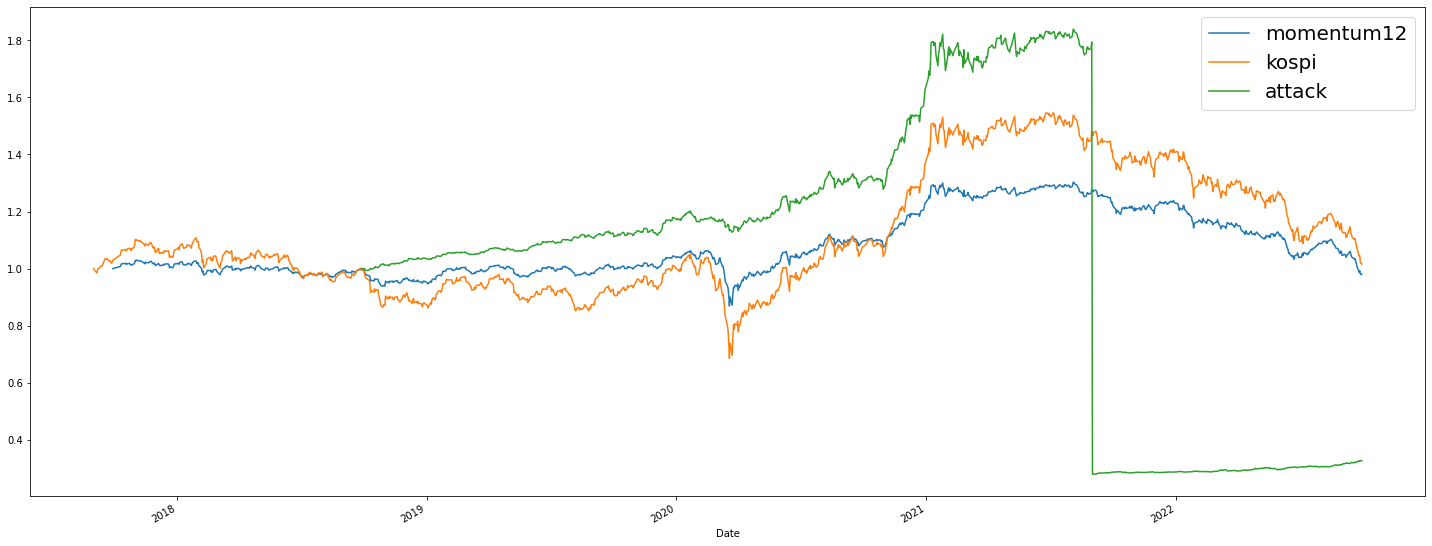

In [85]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(25,10))

momentum12CumReturn.plot(label="momentum12")
kospiCumReturn.plot(label="kospi")
dollar12CumReturn.plot(label="attack")

plt.legend(fontsize=20)
plt.show()